## Analysis of ligand-receptor interactions across boundaries

- Calculate interaction likelihood in both directions for a given ligand-receptor (LR) pair
- Plot interaction potentials for each cell pair between two cell types for each LR pair
- Rank interaction likelihoods for all LR pairs defined from the CellChat database

Select dataset - can be one of `dataset_1`, `dataset_2`, `dataset_3` \
Note: To run this notebook successfully, please ensure that [01_biophysical_analysis.ipynb](01_biophysical_analysis.ipynb) has been run and required temporary files have been generated

In [1]:
dataset = 'dataset3'

Module imports

In [2]:
%matplotlib inline
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from helper_functions import *

Data import

In [3]:
# Gene expression matrix, cell adjacency matrix, force imputation results
gex_res = pd.read_csv(f'../reproduce_data/{dataset}/gex_res.csv', index_col=0)
adj_mat = pd.read_csv(f'../reproduce_data/{dataset}/adj_mat.csv', index_col=0)
tensionmap_data = pd.read_csv(f'../reproduce_data/{dataset}/tensionmap_res.csv', index_col=0)

# Define celltypes on either side of boundary
boundary_celltypes = np.unique(tensionmap_data['boundary_annotation'].values)
boundary_celltypes = boundary_celltypes[boundary_celltypes != 'Other']

# distance_to_boundary object is calculated in the previous step
distance_to_boundary = pd.read_csv('./temp_data/distance_to_boundary.csv', index_col=0)
boundary_tensions = pd.read_csv('./temp_data/boundary_tensions.csv', index_col=0)

Load set of LR interactions - here, we use CellChatDB, but any correctly formatted object containing ligand-receptor pairs can be used.

In [4]:
# Load previously downloaded set of CellChatDB interactions from OmniPath
# request is https://omnipathdb.org/interactions?databases=CellChatDB&genesymbols=1&organisms=10090

interactions = pd.read_csv('../reproduce_data/omnipath_cellchatdb.txt', sep='\t')

# Filter for interactions where both genes are expressed with frequency > 0.5 across the entire dataset
expressed_genes = gex_res.index.values[gex_res.apply(lambda x: np.sum(x>0), axis=1) > 0.5*gex_res.shape[1]]
interactions = interactions.iloc[np.where(np.logical_and(np.isin(interactions['source_genesymbol'].values, expressed_genes), (np.isin(interactions['target_genesymbol'].values, expressed_genes))))[0],]
interactions = interactions[['source_genesymbol', 'target_genesymbol']]


Perform LR analysis - compute interaction potential for each cell pair and interaction likelihood for each pair of cell types across all LR pairs

In [5]:
# Construct metadata for each cell-cell junction

boundary_cells = tensionmap_data.index.values[np.where(np.logical_and(np.isin(tensionmap_data['boundary_annotation'], boundary_celltypes), distance_to_boundary['distance'] <= 5))[0]]
boundary_adj_mat = adj_mat.loc[boundary_cells, boundary_cells]
edge_indices = np.nonzero(np.triu(boundary_adj_mat))
boundary_metadata = pd.DataFrame(data=np.array([boundary_adj_mat.columns.values[edge_indices[0]], boundary_adj_mat.columns.values[edge_indices[1]]]).T,
                                 columns=['cell_1', 'cell_2'])
boundary_metadata['cell_1_celltype'] = tensionmap_data.loc[boundary_metadata['cell_1'], 'boundary_annotation'].values
boundary_metadata['cell_2_celltype'] = tensionmap_data.loc[boundary_metadata['cell_2'], 'boundary_annotation'].values

In [6]:
interactions_res = test_interactions(interactions, gex_res, boundary_metadata, boundary_celltypes)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:01<00:00, 125.96it/s]


In [7]:
from scipy.stats import rankdata
interactions_res['ab_rank'] = len(interactions_res['ab_likelihood']) - rankdata(interactions_res['ab_likelihood'])
interactions_res['ba_rank'] = len(interactions_res['ab_likelihood']) - rankdata(interactions_res['ba_likelihood'])
interactions_res['ab_likelihood_abs'] = np.abs(interactions_res['ab_likelihood'])
interactions_res['ba_likelihood_abs'] = np.abs(interactions_res['ba_likelihood'])
interactions_res['ab_rank_abs'] = len(interactions_res['ab_likelihood']) - rankdata(np.abs(interactions_res['ab_likelihood']))
interactions_res['ba_rank_abs'] = len(interactions_res['ab_likelihood']) - rankdata(np.abs(interactions_res['ba_likelihood']))

### Generate plots

#### Boxplots of cellpair interaction potentials for top 5 LR interactions

Define alises to have shorter x-axis labels.

- Data set 1: `['CM','FMH']`
- Data set 2: `['Hindbrain','Midbrain']`
- Data set 3: `['FMH', 'NC']`

In [8]:
aliases = ['FMH','NC']

Top FMH->NC interaction:


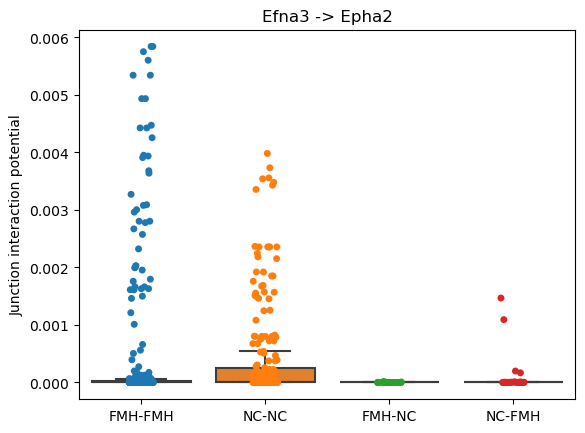

Top NC->FMH interaction:


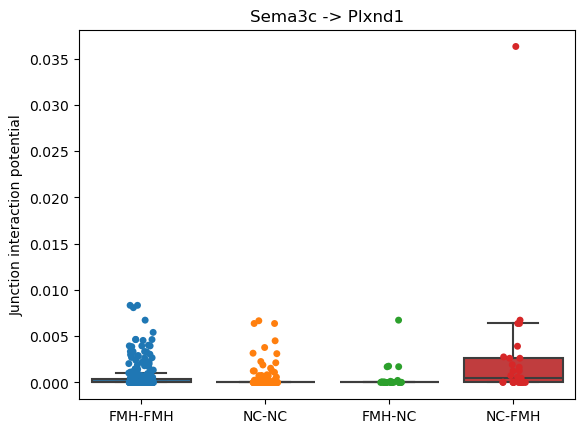

In [9]:
print(f'Top {aliases[0]}->{aliases[1]} interaction:')
for i,interaction in interactions_res.loc[interactions_res['ab_type']!='inconsistent'].sort_values(by='ab_likelihood',ascending=False).iloc[0:1,].iterrows():
    genes = [interaction['source_gene'],interaction['target_gene']]
    generate_boxplot(genes[0],genes[1], gex_res, boundary_metadata, boundary_celltypes, celltype_alias=aliases)
    plt.show()

print(f'Top {aliases[1]}->{aliases[0]} interaction:')
for i,interaction in interactions_res.loc[interactions_res['ba_type']!='inconsistent'].sort_values(by='ba_likelihood',ascending=False).iloc[0:1,].iterrows():
    genes = [interaction['source_gene'],interaction['target_gene']]
    generate_boxplot(genes[0],genes[1], gex_res, boundary_metadata, boundary_celltypes, celltype_alias=aliases)
    plt.show()

#### Dotplot of ranked LR interactions

Ranked dotplot of FMH->NC interactions:


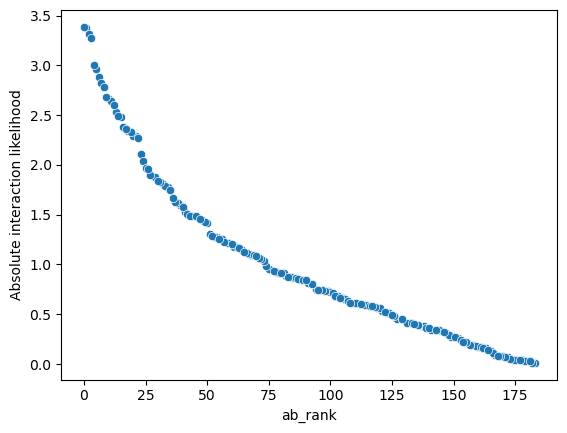

In [10]:
# Dotplot for A-B interactions
print(f'Ranked dotplot of {aliases[0]}->{aliases[1]} interactions:')
sns.scatterplot(data=interactions_res[interactions_res['ab_likelihood']>0], x='ab_rank',y='ab_likelihood_abs').set(ylabel = 'Absolute interaction likelihood')
plt.show()

Ranked dotplot of NC->FMH interactions:


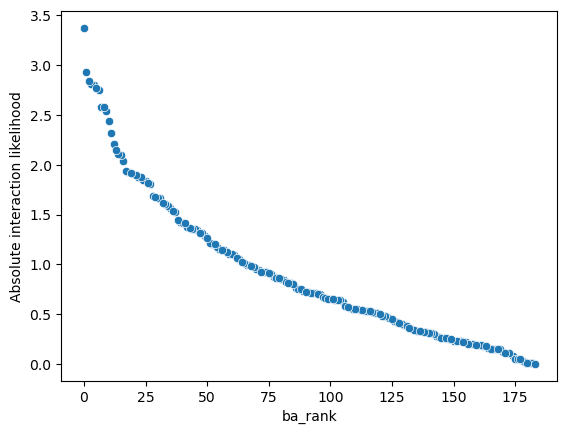

In [11]:
# Dotplot for B-A interactions
print(f'Ranked dotplot of {aliases[1]}->{aliases[0]} interactions:')
sns.scatterplot(data=interactions_res[interactions_res['ba_likelihood']>0], x='ba_rank',y='ba_likelihood_abs').set(ylabel = 'Absolute interaction likelihood')
plt.show()

In [12]:
# Save results
interactions_res.to_csv('./temp_data/lr_interactions_res.csv', index=False)

In [13]:
# Output gene expression line plots and spatial plots for top LR gene pairs

# Segmented image and cell positions for spatial plots

img_path = skimage.io.imread(f'../reproduce_data/{dataset}/segmentation_final.tif')
cell_positions = tensionmap_data[['centroid_x', 'centroid_y']]/2

#### Visualise 2D spatial gene expression plots and 1D boundary line plots for top LR pair

Gene expression plots for top ranked FMH -> NC interaction
Plots for ligand gene Sema3c


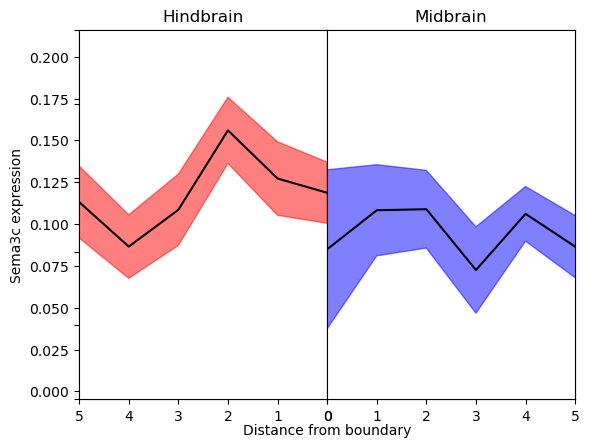

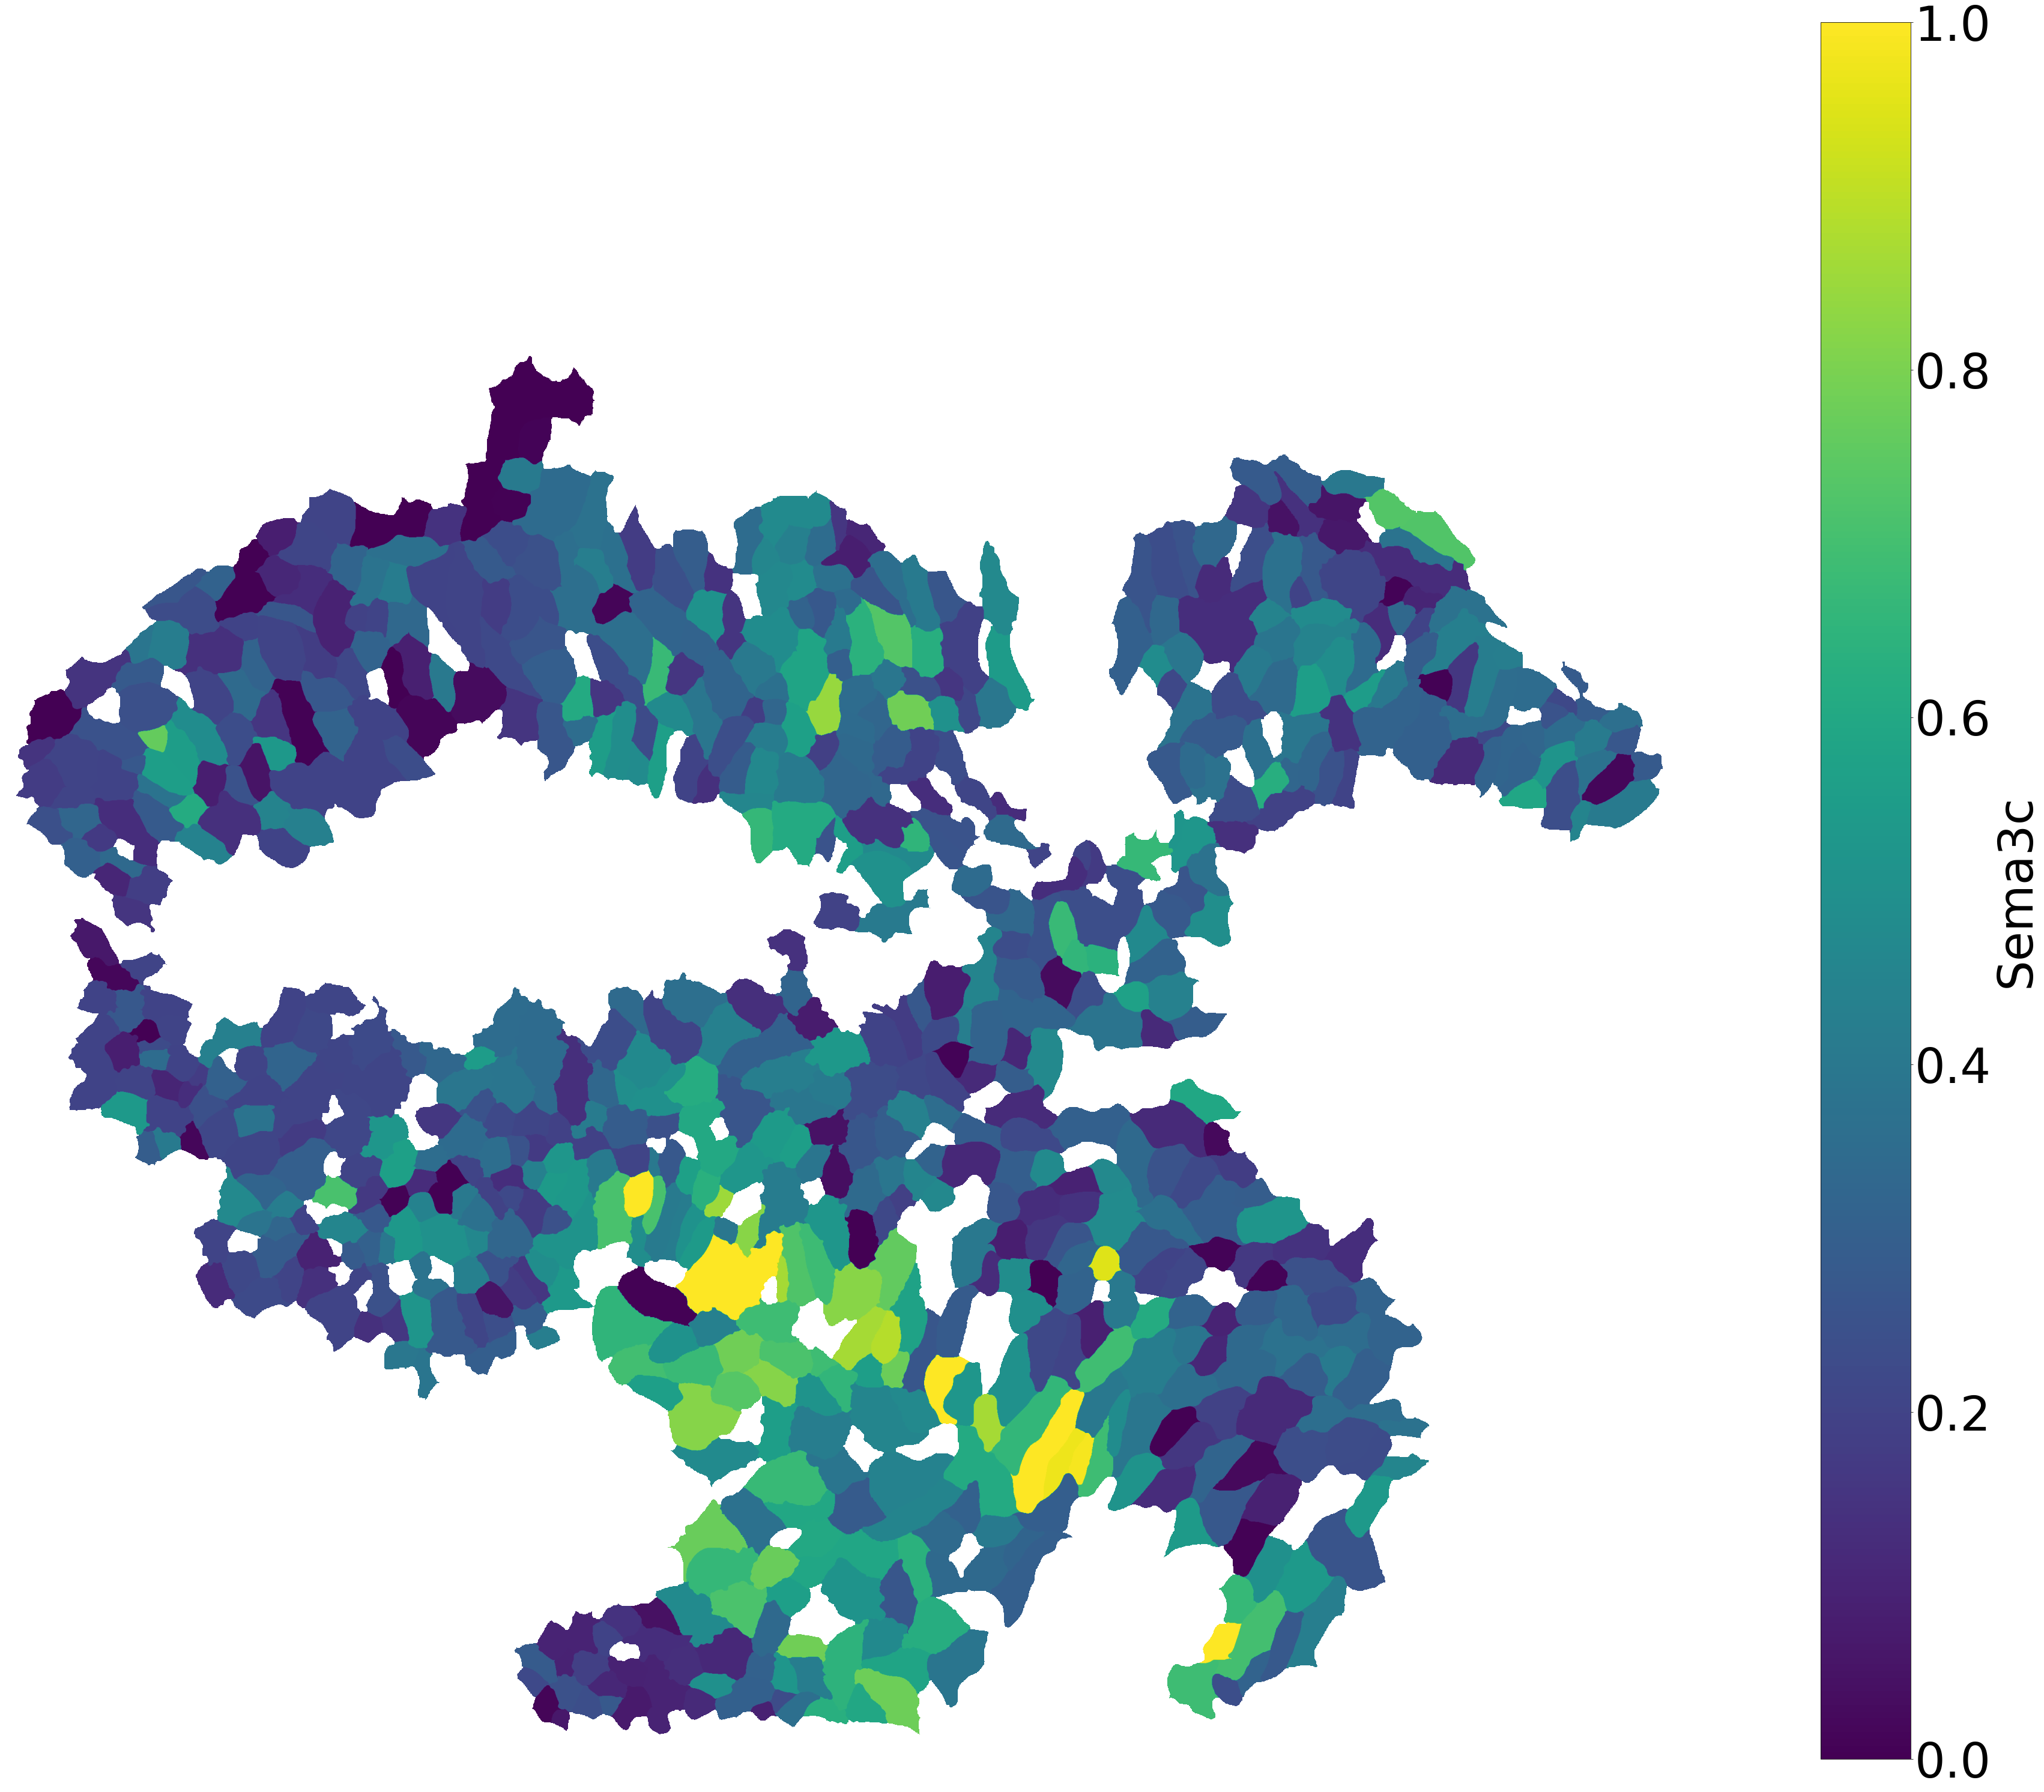

Plots for ligand gene Plxnd1


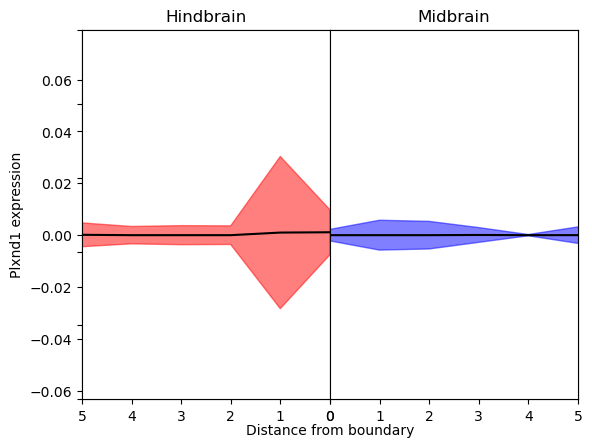

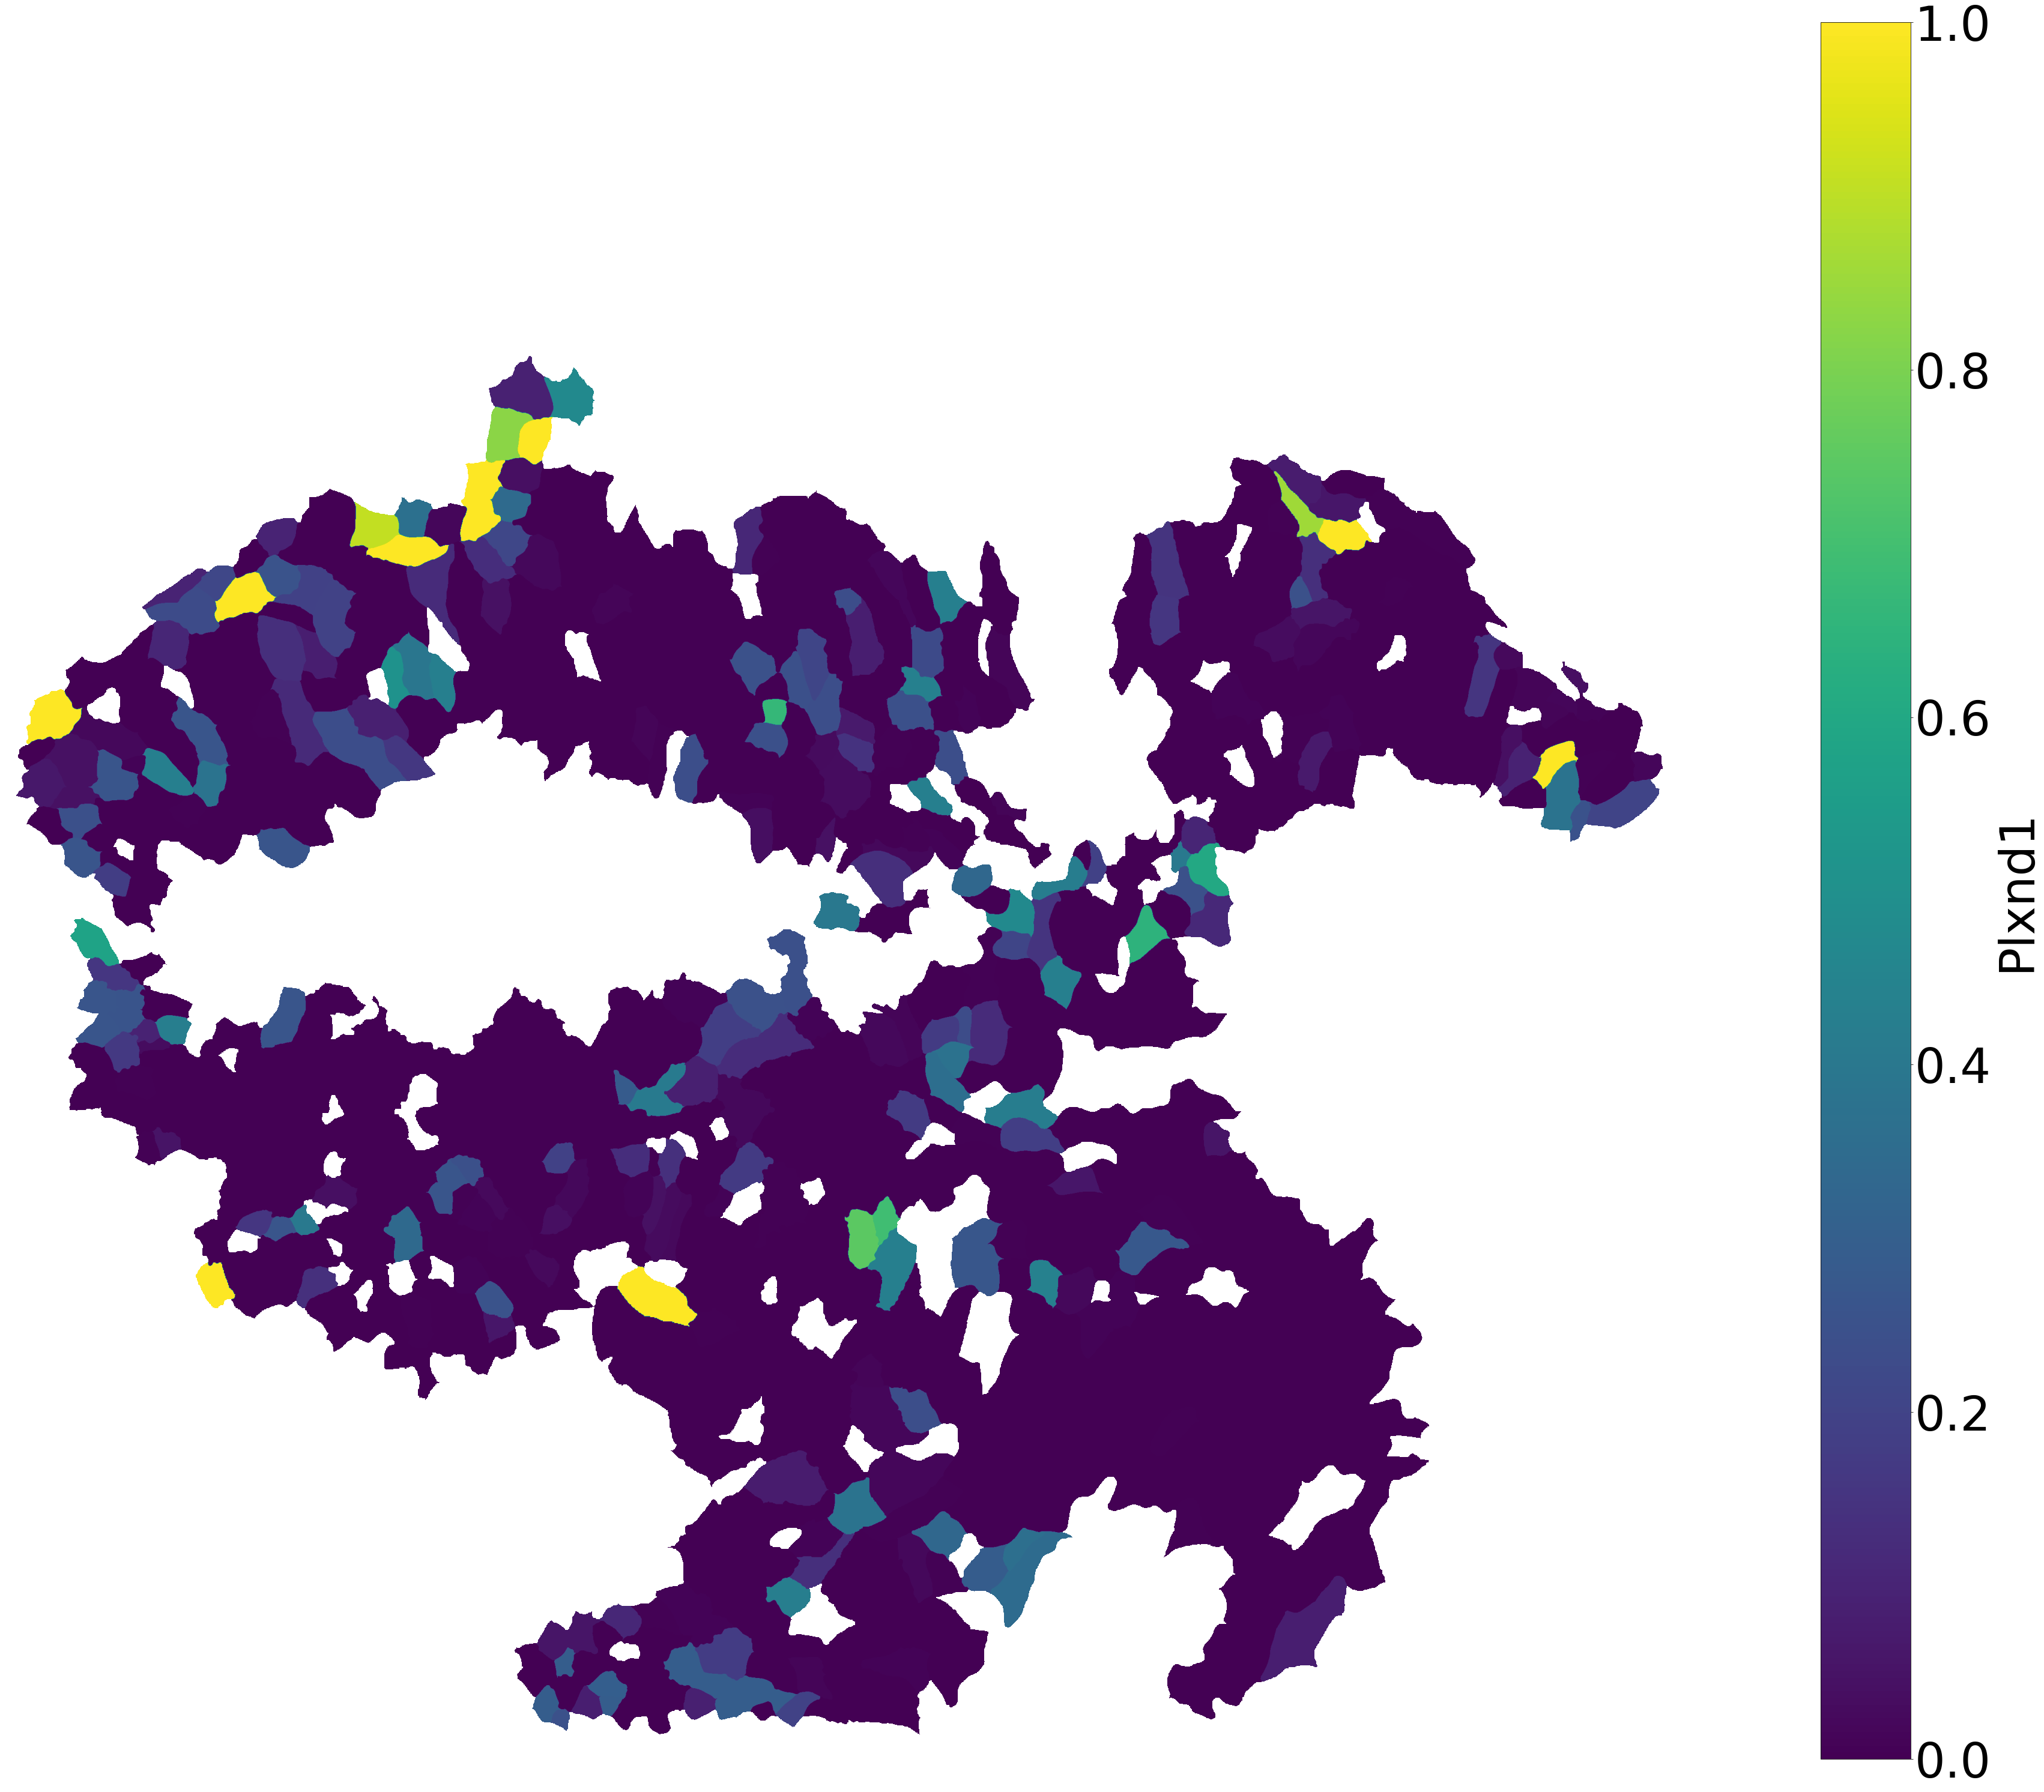

In [14]:
# B-A interactions

print(f'Gene expression plots for top ranked {aliases[0]} -> {aliases[1]} interaction')
for i, interaction in interactions_res.loc[interactions_res['ba_type']!='inconsistent'].sort_values(by='ba_likelihood',ascending=False).iloc[0:1,].iterrows():
    # Do ligand plots
    print(f'Plots for ligand gene {interaction["source_gene"]}')
    gex_lineplot(interaction['source_gene'], tensionmap_data, boundary_celltypes, distance_to_boundary, gex_res, [5,0], [0,5])
    spatialplot(gex_res.loc[interaction['source_gene']].values, 'continuous', cell_positions, img_path, legend=interaction['source_gene'], size=80, norm=True)

    # Do receptor plots
    print(f'Plots for ligand gene {interaction["target_gene"]}')
    gex_lineplot(interaction['target_gene'], tensionmap_data, boundary_celltypes, distance_to_boundary, gex_res, [5,0], [0,5])
    spatialplot(gex_res.loc[interaction['target_gene']].values, 'continuous', cell_positions, img_path, legend=interaction['target_gene'], size=80, norm=True)

Gene expression plots for top ranked NC -> FMH interaction
Plots for ligand gene Efna3


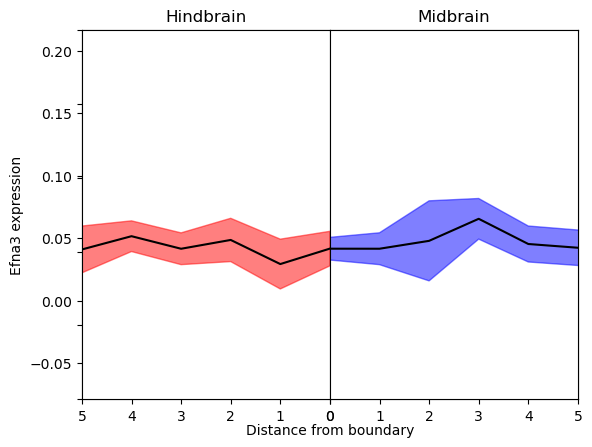

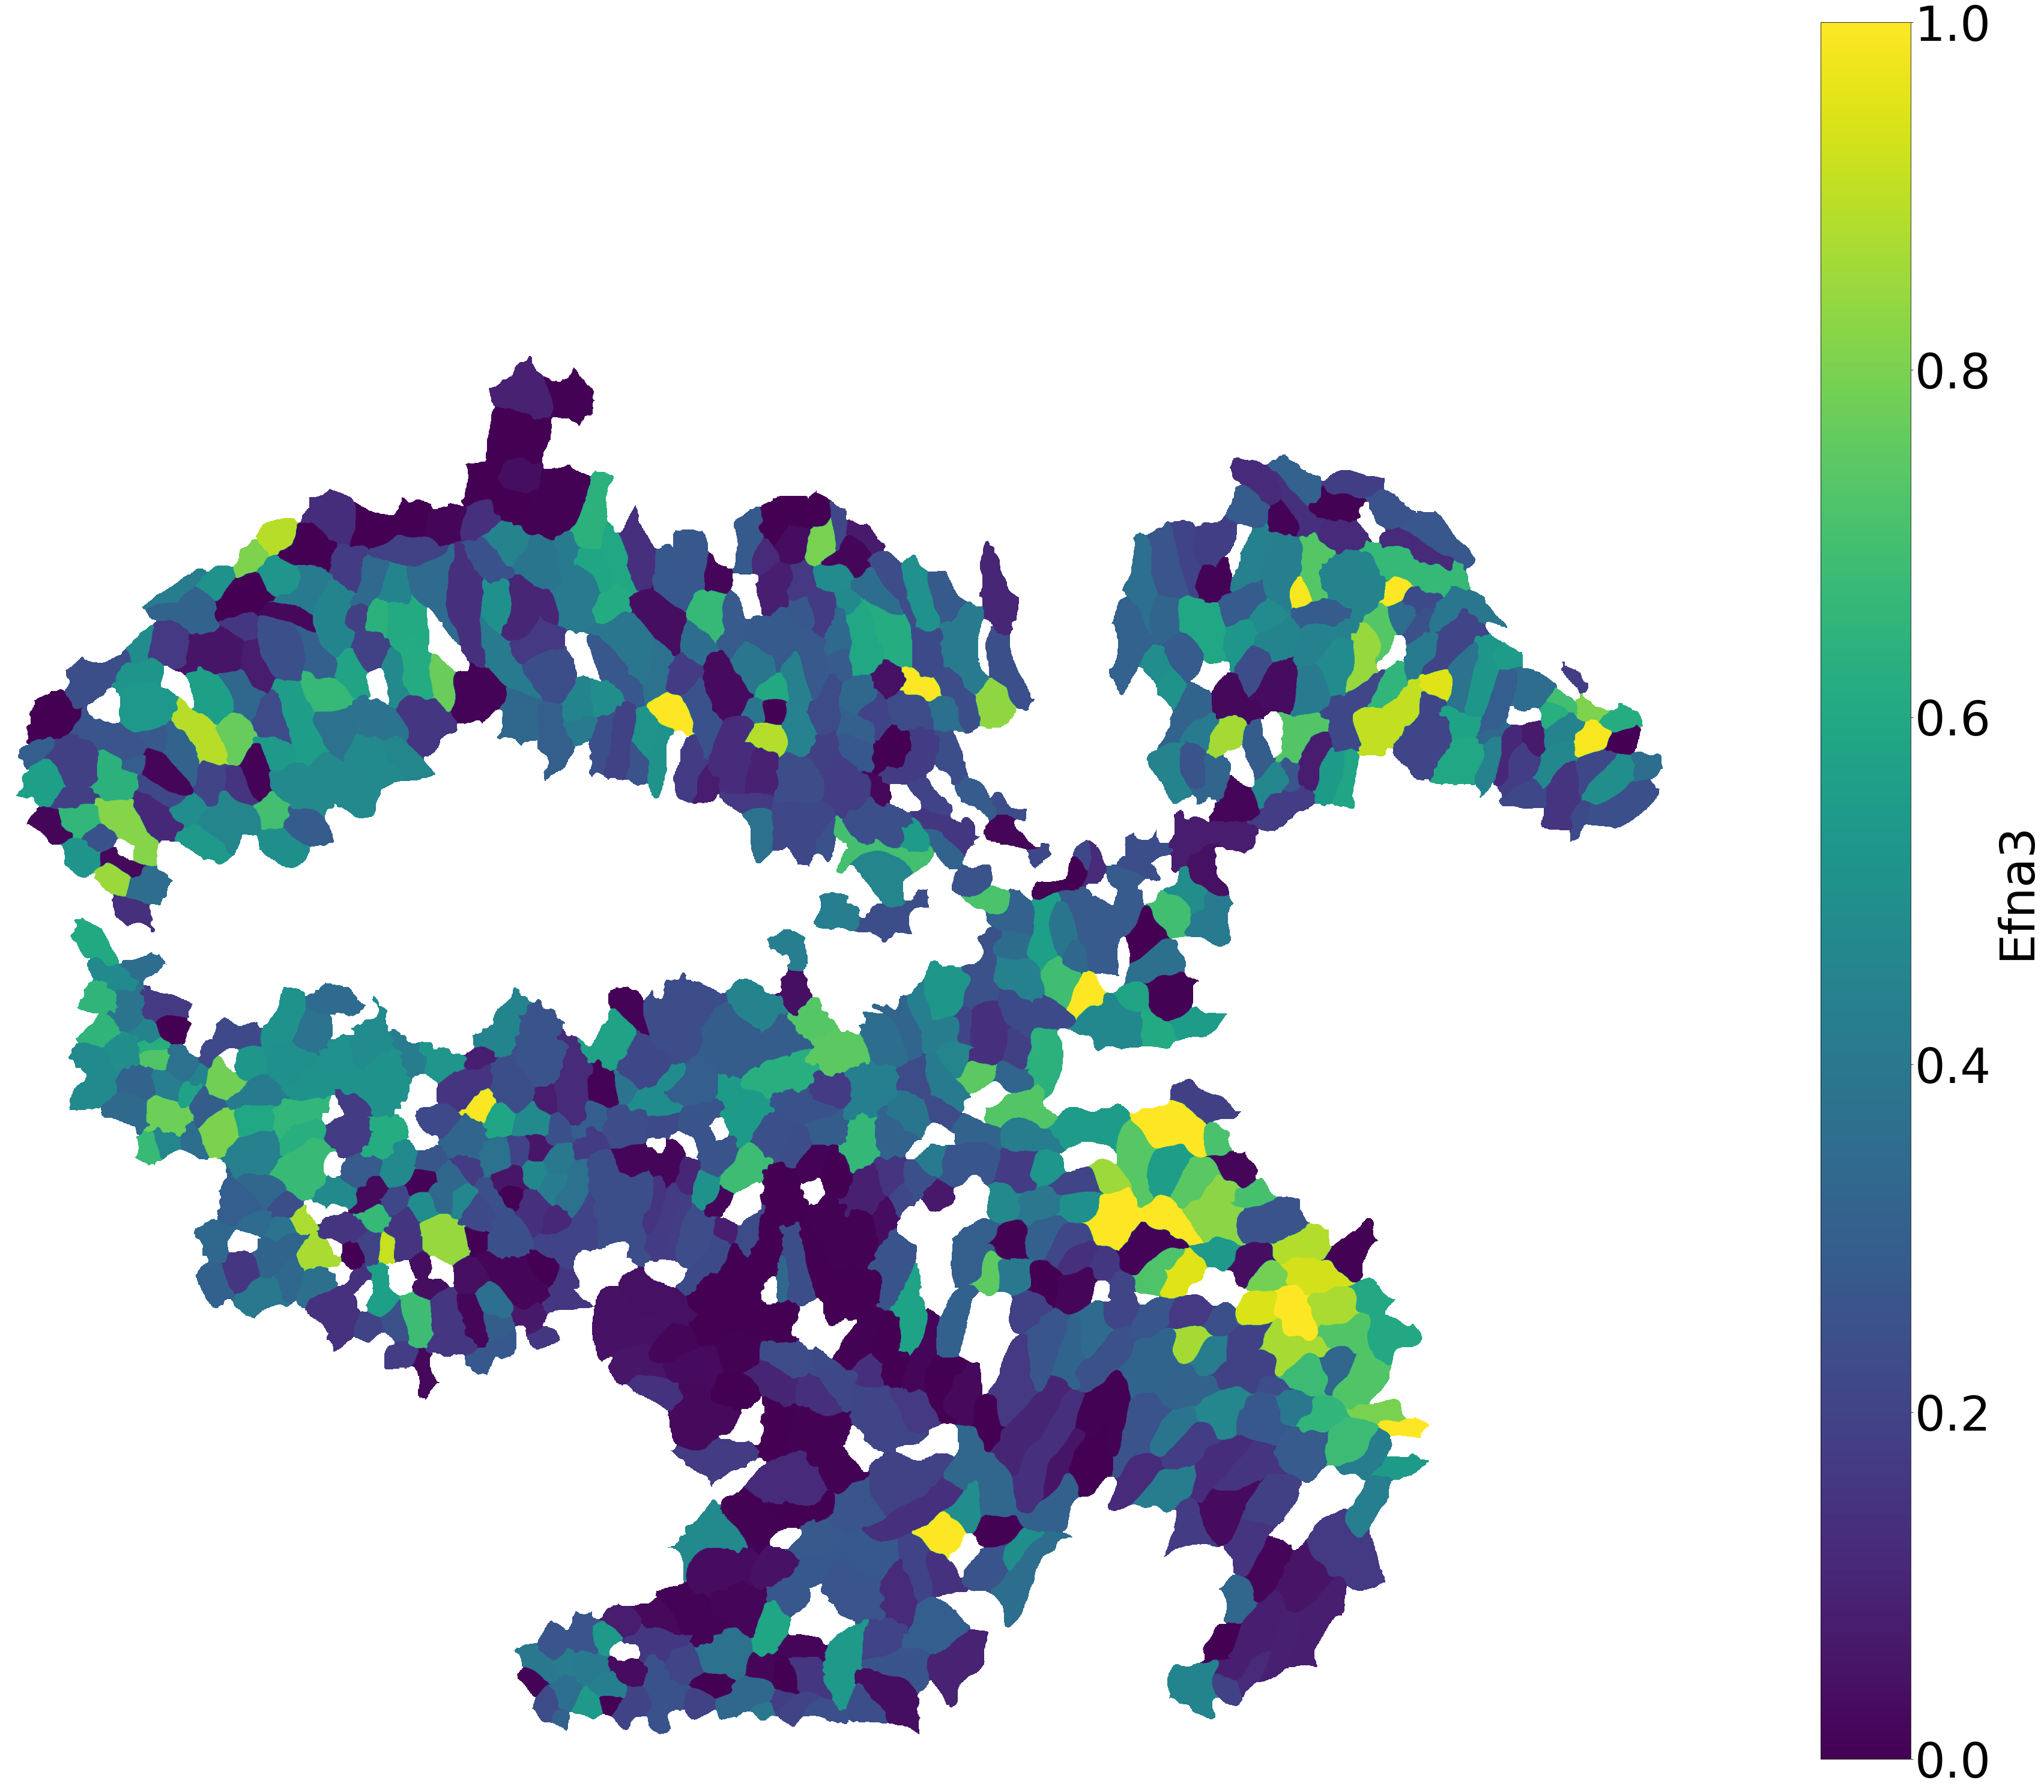

Plots for ligand gene Epha2


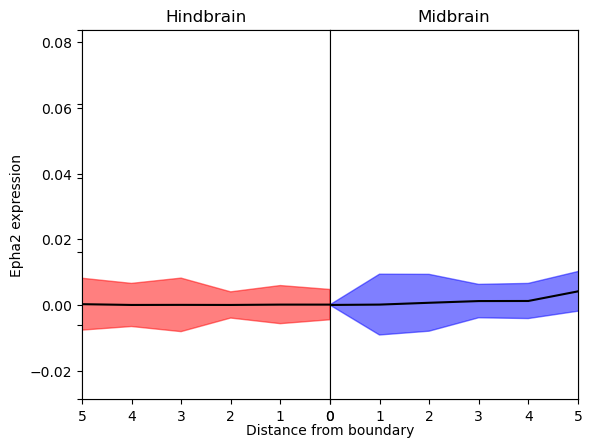

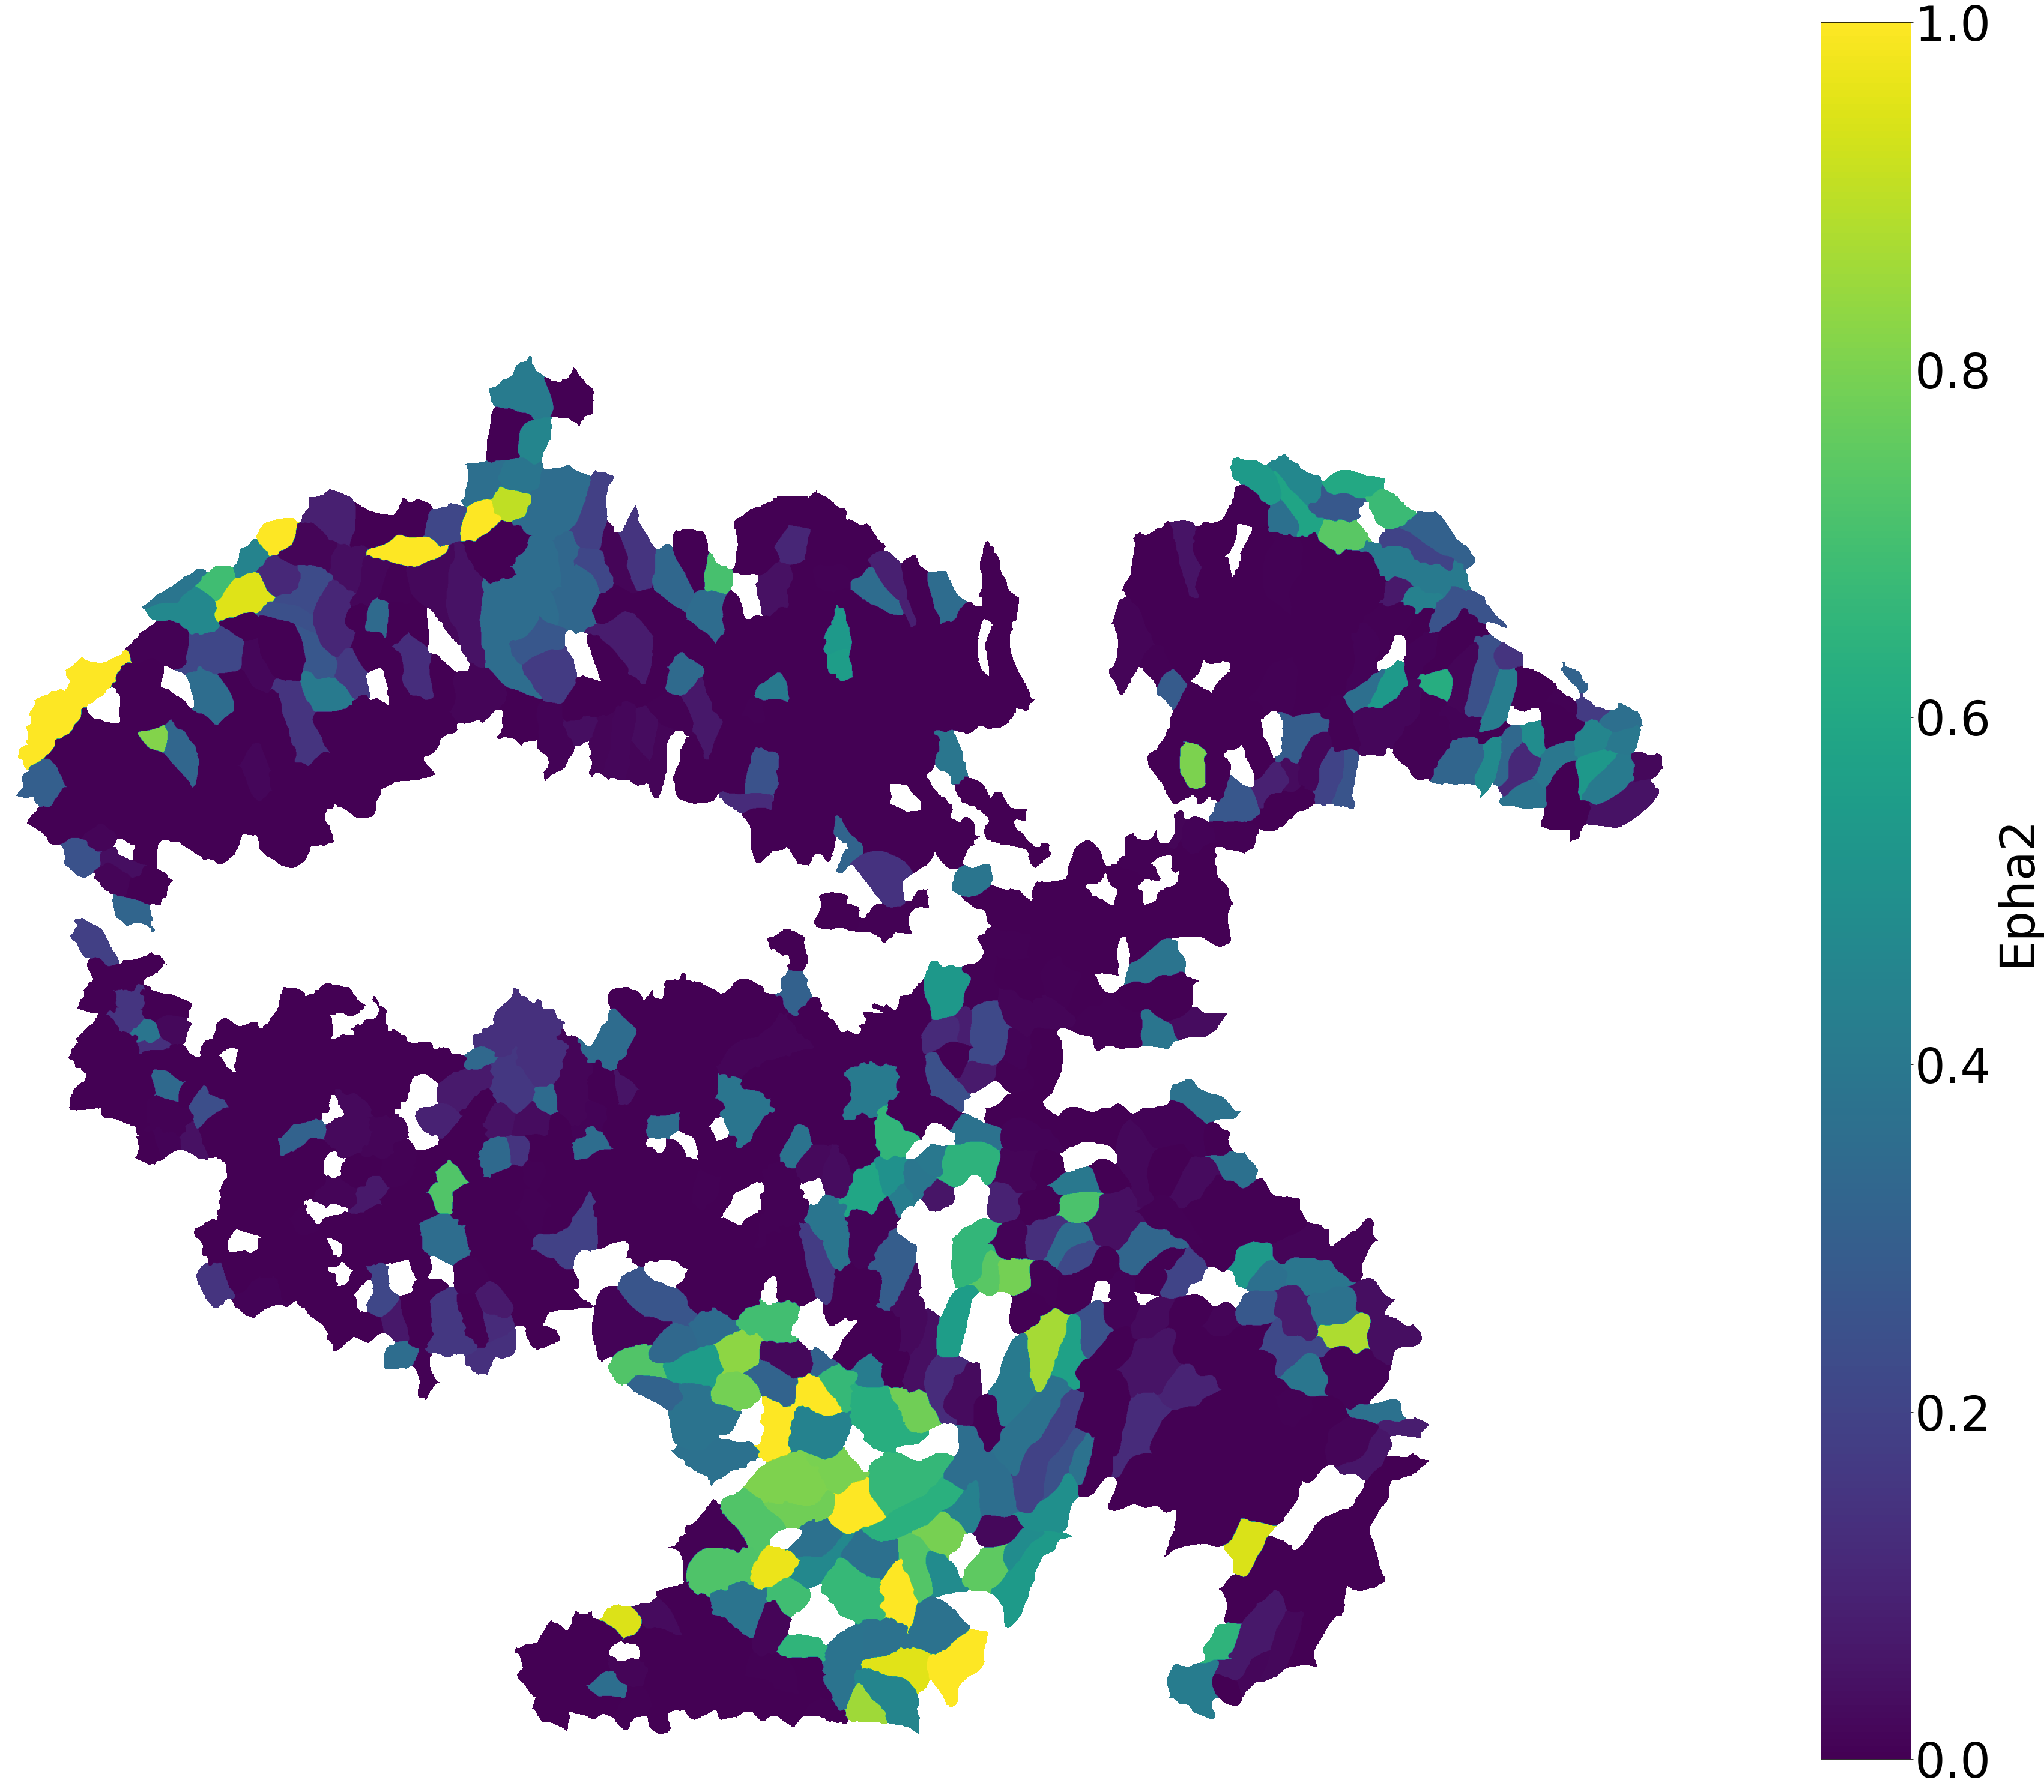

In [15]:
# A-B interactions

print(f'Gene expression plots for top ranked {aliases[1]} -> {aliases[0]} interaction')
for i, interaction in interactions_res.loc[interactions_res['ab_type']!='inconsistent'].sort_values(by='ab_likelihood',ascending=False).iloc[0:1,].iterrows():
    # Do ligand plots
    print(f'Plots for ligand gene {interaction["source_gene"]}')
    gex_lineplot(interaction['source_gene'], tensionmap_data, boundary_celltypes, distance_to_boundary, gex_res, [5,0], [0,5])
    spatialplot(gex_res.loc[interaction['source_gene']].values, 'continuous', cell_positions, img_path, legend=interaction['source_gene'], size=80, norm=True)

    # Do receptor plots
    print(f'Plots for ligand gene {interaction["target_gene"]}')
    gex_lineplot(interaction['target_gene'], tensionmap_data, boundary_celltypes, distance_to_boundary, gex_res, [5,0], [0,5])
    spatialplot(gex_res.loc[interaction['target_gene']].values, 'continuous', cell_positions, img_path, legend=interaction['target_gene'], size=80, norm=True)